# Optimal Growth I, II and III: The Stochastic Optimal Growth Model

## Value Function and (Euler equation) Time Iteration

Based on: https://python.quantecon.org/optgrowth.html

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /opt/anaconda3/lib/python3.7/site-packages (0.4.6)


In [20]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from interpolation import interp
from numba import jit, njit, jitclass, prange, float64, int32
from quantecon.optimize.scalar_maximization import brent_max
from quantecon.optimize import brentq

%matplotlib inline

#### Interpolation

We store the value function on a grid and use interpolation to recreate it.

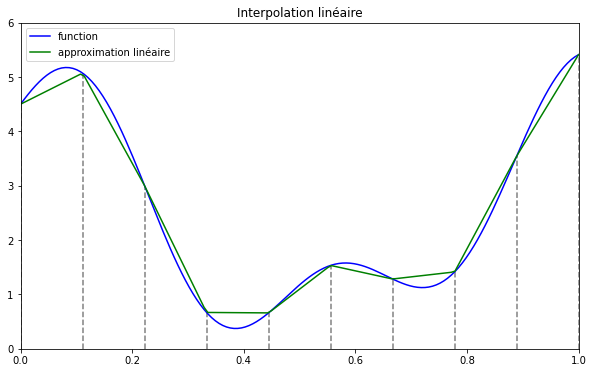

In [21]:
def f(x):
    y1 = 2 * np.cos(6 * x) + np.sin(14 * x)
    return y1 + 2.5

def Af(x):
    return interp(c_grid, f(c_grid), x)

c_grid = np.linspace(0, 1, 10)
f_grid = np.linspace(0, 1, 150)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(f_grid, f(f_grid), 'b-', label='function')
ax.plot(f_grid, Af(f_grid), 'g-', label='approximation linéaire')
ax.vlines(c_grid, c_grid * 0, f(c_grid), linestyle='dashed', alpha=0.5)
ax.set(xlim=(0, 1), ylim=(0, 6))
ax.legend(loc='upper left')
ax.set_title('Interpolation linéaire')
save_results_to = '/Users/guillaumesublet/Dropbox/Economics/Teaching/Montreal/ECN_7055/I_Marches_complets/Cours2_Methodes_Numeriques/'
plt.savefig(save_results_to + 'ECN7055_Interpolation.pdf', dpi = 300)
plt.show()

### Neoclassical Growth Model

Recursive formulation of the planner problem:
\begin{align*}
v(k, \xi) &= \max_{c,k} \left\{ u(c) + \beta E[v(k', \xi')] \right\} \\
    &c + (k' - (1-\delta) k) = \xi \ f(k) \\
    &\xi, \xi' \sim_{iid} \phi
\end{align*}

Suppose that there is full depreciation (that is, $\delta = 1$). We no longer need to keep track of the capital stock. We can then drop the state variable $\xi$ and reexpress the problem in terms of output as follows:
\begin{align*}
v(y) &= \max_c \left\{ u(c) + \beta E[v(y')] \right\} \\
    y' &= \xi \ f(y - c) \\
    \xi &\sim \phi
\end{align*}

Parametrization of the problem
\begin{align*}
\delta &=1 \\
u(c) &= \ln(c) \\
f(k) &= k^\alpha \\
\phi(\xi) &= \exp(\mu + s \zeta) \ \text{where} \ \zeta \sim N(0,1)
\end{align*}

### Computations 

#### Value Function Iterations

##### Algorithm:
1. initial guess of $v_0$ on a grid $(y_1, ..., y_I)$ and fix tolerance
2. Build function by interpolating $v_t$ 
3. Compute $v_{t+1}$ on each grid point $y_i$ as follows:
\begin{align*}
v_{t+1}(y_i) &= \max_c \left\{ u(c) + \beta E[v_t(y')] \right\} \\
    y' &= \xi \ f(y_i - c) \\
    \xi &\sim \phi
\end{align*}
3. If $sup_{y \in \{y_1, ..., y_I\} } \ | \ (v_{t+1}(y) - v_t(y)) \ | < tolerance$, then stop, otherwise back to 2

#### Implementation of the algorithm

Matlab: since Matlab is particularly fast at handling matrices, the way to implement this algorithm in Matlab is to create matrices whose dimension is (number of first state times number of second state time ... times number of grid point for the choice variable) and then optimize over the dimension representing the choice variable.

Python: since python is good at handling loops, we will implement this algorithm with a loop where for each state, we will optimize w.r.t. the choice variable.


1. Numba: to use numba JIT which makes the code fast, we specifiy the types of the data
2. Function that is the right hand side of the Bellman equation $u(c) + \beta E[v_t(\xi \ f(y_i - c))]$
3. Bellman operator (contraction) $T$ which, for each $y$ maximizes the function defined in 2 and maps $v_t$ into $v_{t+1}$ 
4. Get policy function associated with a $v$

In [22]:
'This is to be able to use JIT from Numba to speed up the code, which will be done with at jitclass before the class'
opt_growth_data = [
    ('alpha', float64), # power of production function
    ('beta', float64), # discount factor
    ('mu', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

In [23]:
@jitclass(opt_growth_data) #jitclass because we are building a class
class QE_OptimalGrowth():
    def __init__(self,
                alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 4,
                grid_size = 200,
                shock_size = 250):
        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 
        self.grid = np.linspace(1e-5, grid_max, grid_size) # set up the grid for the state y
        self.shocks = np.exp(mu + s * np.random.randn(shock_size)) # draw some shocks to take expectations
    
    def f(self, k):
        return k**self.alpha
    
    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)
    
    def u(self, c):
        return np.log(c)
    
    def u_prime(self, c):
        return 1/c
    
    def RHS_Bellman(self, c, y, v_array):
        'returns the right hand side for a given choice c and a given state y'
        u, f, beta, shocks = self.u, self.f, self.beta, self.shocks
        v = lambda x: interp(self.grid, v_array, x)
        return u(c) + beta * np.mean(v(f(y-c) * shocks)) #np.mean computes the expectation over shock_size draws

    def RHS_ColemanReffett(self, c, y, c_array):
        'returns the right hand side for a given choice c and a given state y'
        pol = lambda x: interp(self.grid, c_array, x)
        return self.u_prime(c) - self.beta * np.mean(self.u_prime(pol(self.f(y - c) * self.shocks)) * self.f_prime(y - c) * self.shocks)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  """Entry point for launching an IPython kernel.


#### Value Function Iteration

In [24]:
@jit #(nopython=True) # jit because we are defining a function
def T_Bellman(og, v):
    ''' 
    og is an instance of the class QE_OptimalGrowth
    v is our guess of value function, an array of size grid_size in the class QE_OptimalGrowth
    '''
    
    v_prime = np.empty_like(v) # creates a vector of the same size as v that will record v' 
    
    for i in range(len(og.grid)):
        y = og.grid[i]
        vprime = brent_max(og.RHS_Bellman, 1e-10, y, args=(y, v))[1] # maximize over c between 1e-10 et y
        v_prime[i] = vprime
    return v_prime

In [25]:
@jit #(nopython=True) # jit because we are defining a function
def v_greedy(og, v):
    ''' 
    og is an instance of the class QE_OptimalGrowth
    v is our guess of value function, an array of size grid_size in the class QE_OptimalGrowth
    '''
    c = np.empty_like(v)
    for i in range(len(og.grid)):
        y = og.grid[i]
        policy = brent_max(og.RHS_Bellman, 1e-10, y, args=(y, v))[0] # maximize over c between 1e-10 et y
        c[i] = policy
    return c

#### Time Iterations: Euler equation method

Instead of iterating on the value function, we iteration on the Euler equation. The notes on QuantEcon show the equivalence of these two methods in theory. In practice, however, Euler equation method is can be faster since the approximation of the policy function is easier.

For every $y$, the policy function $c = c(y)$ solves the Euler equation:
\begin{equation*}
u'(c) = \beta \int \ v'(f(y - c) z) \ f'(y - c) z \phi dz
\end{equation*}

By the envelope condition:
\begin{equation*}
v'(y) = \beta \int \ v'(f(y - c) z) \ f'(y - c) z \phi dz = u'(c(y)) = (u' \circ c)(y)
\end{equation*}

Substituting the envelope condition into the Euler equation allows to write the policy as a fixed point of a functional equation:
\begin{equation*}
u'(c(y)) = \beta \int \ (u' \circ c)(f(y - c(y)) z) \ f'(y - c(y)) z \phi dz
\end{equation*}

Mapping from guess $c_\tau$ to updated guess $c_{\tau+1}$,
that is there is an operator $K$ for which $c_{\tau + 1} = K(c_\tau)$ where $K$ is the Coleman-Reffett operator

for every $y$, the updated policy is $c_{\tau+1}(y)$ which solves:
\begin{equation*}
u'(c) = \beta \int \ (u' \circ c_\tau)(f(y - c) z) \ f'(y - c) z \phi dz
\end{equation*}
That is, for all $y$:
\begin{equation*}
u'(c_{\tau+1}(y)) = \beta \int \ (u' \circ c_\tau)(f(y - c_{\tau+1}(y)) z) \ f'(y - c_{\tau+1}(y)) z \phi dz
\end{equation*}

In [26]:
@jit(nopython=True) # jit because we are defining a function
def T_ColemanReffett(og, c_array):
    ''' 
    og is an instance of the class QE_OptimalGrowth
    c_array is our guess of policy function, an array of size grid_size in the class QE_OptimalGrowth
    '''
    
    c_prime = np.empty_like(c_array) # creates a vector of the same size as c_array that will record c' 
    
    for i in range(len(og.grid)):
        y = og.grid[i]
        cprime = brentq(og.RHS_ColemanReffett, 1e-10, y-1e-10, args=(y, c_array))[0]
        c_prime[i] = cprime
    
    return c_prime

#### Exact solution

In [27]:
def Exact_policy(og, y):
    """
    True optimal policy
    """
    return (1 - og.alpha * og.beta) * y

def Exact_v(og, y):
    """
    True value function
    """
    c1 = np.log(1 - og.alpha * og.beta) / (1 - og.beta)
    c2 = (og.mu + og.alpha * np.log(og.alpha * og.beta)) / (1 - og.alpha)
    c3 = 1 / (1 - og.beta)
    c4 = 1 / (1 - og.alpha * og.beta)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

#### First test that the exact solution is a fixed point of the Bellman operator

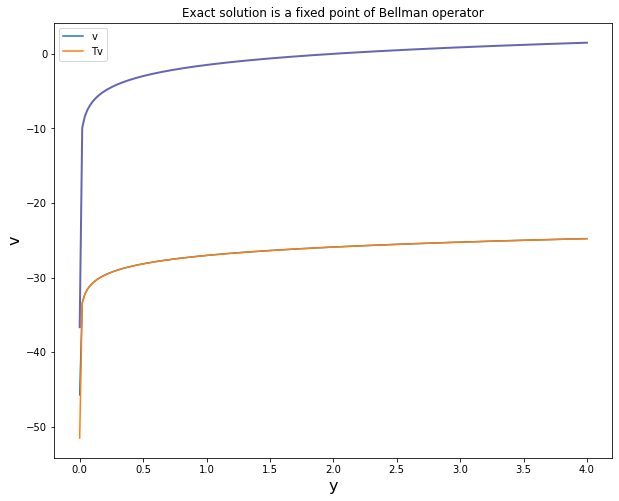

In [30]:
og = QE_OptimalGrowth(alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 4,
                grid_size = 200,
                shock_size = 250)

fig, ax = plt.subplots(figsize=(10,8))
xgrid = og.grid
ax.plot(xgrid, Exact_v(og, xgrid), label='v')
ax.plot(xgrid, T_Bellman(og, Exact_v(og, xgrid)), label='Tv')
v = 3 * np.log(og.grid)
num_iter = 1
for i in range(num_iter):
    v = T_Bellman(og, v)  # Apply the Bellman operator
    ax.plot(xgrid, v, color=plt.cm.jet(i / num_iter), lw=2, alpha=0.6)
ax.set_title('Exact solution is a fixed point of Bellman operator') 
ax.set_xlabel('y', fontsize=16)
ax.set_ylabel('v', fontsize=16)
ax.legend(loc='upper left')
plt.show()

#### First test that the exact solution is a fixed point of the Coleman Reffett operator

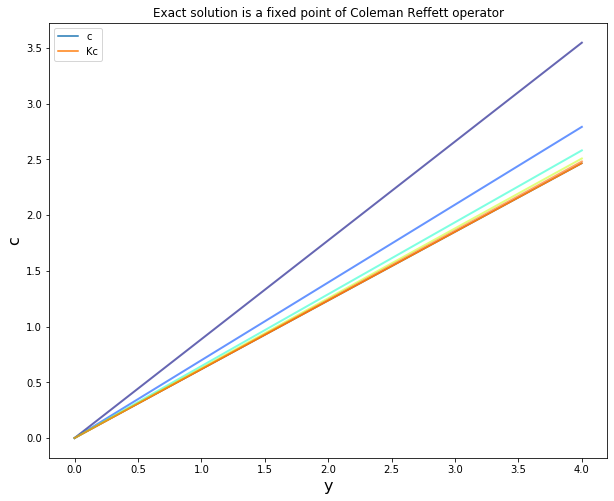

In [17]:
og = QE_OptimalGrowth(alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 4,
                grid_size = 200,
                shock_size = 250)

fig, ax = plt.subplots(figsize=(10,8))
xgrid = og.grid
ax.plot(xgrid, Exact_policy(og, xgrid), label='c')
ax.plot(xgrid, T_ColemanReffett(og, Exact_policy(og, xgrid)), label='Kc')
c_array = 3 * og.grid
num_iter = 5
for i in range(num_iter):
    c_array = T_ColemanReffett(og, c_array)  # Apply the Coleman Reffett operator
    ax.plot(xgrid, c_array, color=plt.cm.jet(i / num_iter), lw=2, alpha=0.6)
ax.set_title('Exact solution is a fixed point of Coleman Reffett operator') 
ax.set_xlabel('y', fontsize=16)
ax.set_ylabel('c', fontsize=16)
ax.legend(loc='upper left')
plt.show()

### Value Function Iteration

In [13]:
def VFI(og, 
        v,
       tol,
       max_iter,
       verbose,
       print_skip):
    ''' 
    og is an instance of the class QE_OptimalGrowth
    v is our guess of value function, an array of size grid_size in the class QE_OptimalGrowth
    '''
    
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T_Bellman(og, v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

Error at iteration 50 is 0.1399190637688008.
Error at iteration 100 is 0.01817349862660933.
Error at iteration 150 is 0.00236047929031713.
Error at iteration 200 is 0.00030659272582056474.
Error at iteration 250 is 3.982203960006814e-05.

Converged in 284 iterations.


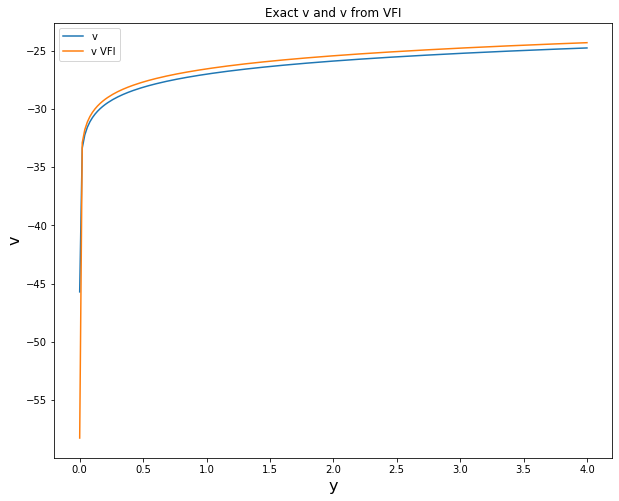

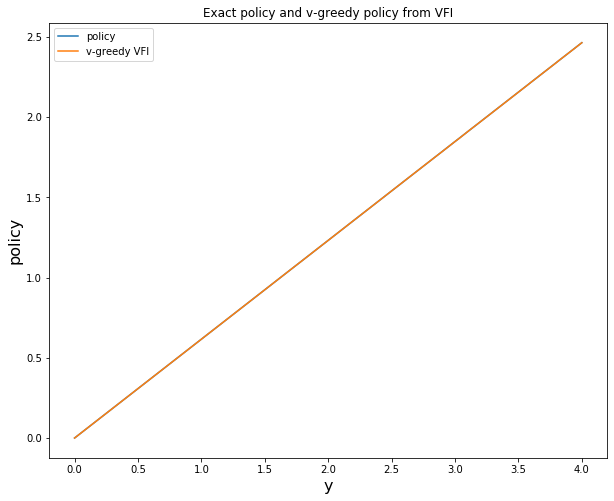

In [14]:
v = 3 * np.log(og.grid) # initial guess

v_VFI = VFI(og, 
            v,
           tol = 1e-5,
           max_iter = 350,
           verbose = True,
           print_skip = 50)

fig, ax = plt.subplots(figsize=(10,8))
xgrid = og.grid
ax.plot(xgrid, Exact_v(og, xgrid), label='v')
ax.plot(xgrid, v_VFI, label='v VFI')
ax.set_title('Exact v and v from VFI') 
ax.set_xlabel('y', fontsize=16)
ax.set_ylabel('v', fontsize=16)
ax.legend(loc='upper left')
plt.show()

fig, ax_1 = plt.subplots(figsize=(10,8))
xgrid = og.grid
ax_1.plot(xgrid, Exact_policy(og, xgrid), label='policy')
ax_1.plot(xgrid, v_greedy(og, v_VFI), label='v-greedy VFI')
ax_1.set_title('Exact policy and v-greedy policy from VFI') 
ax_1.set_xlabel('y', fontsize=16)
ax_1.set_ylabel('policy', fontsize=16)
ax_1.legend(loc='upper left')
plt.show()

### Exercise I: simulations and comparison of different discount factors

Error at iteration 50 is 1.2965841319712013e-05.

Converged in 52 iterations.
Error at iteration 50 is 0.0053371234023043.
Error at iteration 100 is 2.7506334305371638e-05.

Converged in 110 iterations.
Error at iteration 50 is 0.4010988708176626.
Error at iteration 100 is 0.14606804746905055.
Error at iteration 150 is 0.05319355411779725.
Error at iteration 200 is 0.019371479585863938.
Error at iteration 250 is 0.007054505523790056.
Error at iteration 300 is 0.0025690370199384915.
Error at iteration 350 is 0.0009355653899092431.
Error at iteration 400 is 0.000340704548740689.
Error at iteration 450 is 0.000124074266615537.
Error at iteration 500 is 4.518408611176028e-05.
Error at iteration 550 is 1.6454674259591684e-05.

Converged in 575 iterations.


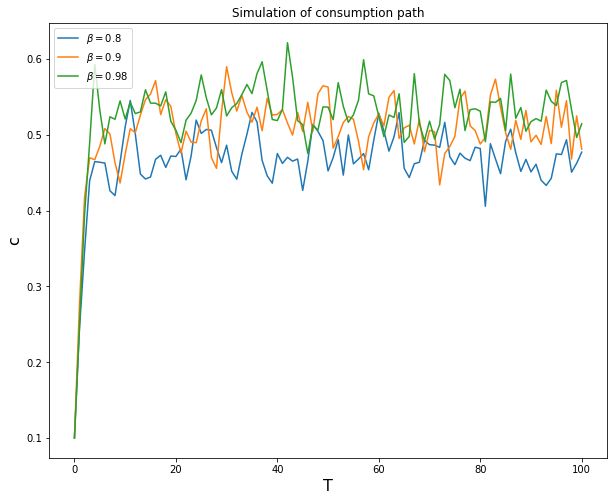

In [13]:
BETA_val = [0.8, 0.9, 0.98]
T = 100
y_0 = 0.1

fig, ax = plt.subplots(figsize=(10,8))
xgrid = np.linspace(0, 100, T+1)
for beta_sim in BETA_val:
    y = np.empty(T+1)
    y[0] = y_0
    og = QE_OptimalGrowth(alpha = 0.4,
                beta= beta_sim,
                mu = 0,
                s = 0.05,
                grid_max = 4,
                grid_size = 200,
                shock_size = 250)
    v_VFI = VFI(og, 
            v,
           tol = 1e-5,
           max_iter = 650,
           verbose = True,
           print_skip = 50)
    
    policy = v_greedy(og, v_VFI)
    policy_interp = lambda x: interp(og.grid, policy, x)
    shocks = np.exp(og.mu + og.s * np.random.randn(T)) # draw some shocks to take expectations
    for i in range(T):
        y[i+1] = shocks[i] * og.f(y[i] - policy_interp(y[i]))
    ax.plot(y, label=rf'$\beta = {beta_sim}$')

ax.set_title('Simulation of consumption path') 
ax.set_xlabel('T', fontsize=16)
ax.set_ylabel('c', fontsize=16)
ax.legend(loc='upper left')
plt.show()    

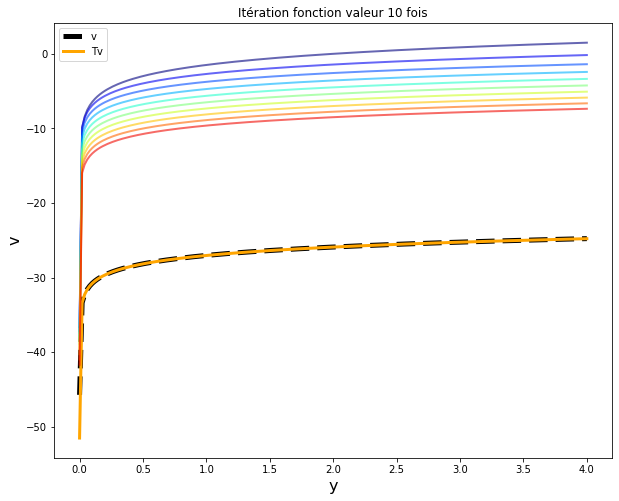

In [14]:
og = QE_OptimalGrowth(alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 4,
                grid_size = 200,
                shock_size = 250)

fig, ax = plt.subplots(figsize=(10,8))
xgrid = og.grid
ax.plot(xgrid, Exact_v(og, xgrid), 'k--', lw=5, label='v')
ax.plot(xgrid, T_Bellman(og, Exact_v(og, xgrid)), color='orange', lw=3, label='Tv')
v = 3 * np.log(og.grid)
num_iter = 10
for i in range(num_iter):
    v = T_Bellman(og, v)  # Apply the Bellman operator
    ax.plot(xgrid, v, color=plt.cm.jet(i / num_iter), lw=2, alpha=0.6)
ax.set_title('Itération fonction valeur %s fois' %num_iter) 
ax.set_xlabel('y', fontsize=16)
ax.set_ylabel('v', fontsize=16)
ax.legend(loc='upper left')
save_results_to = '/Users/guillaumesublet/Dropbox/Economics/Teaching/Montreal/ECN_7055/I_Marches_complets/Cours2_MethodesNumeriques'
plt.savefig(save_results_to + 'ECN7055_VFI.pdf', dpi = 300)
plt.show()

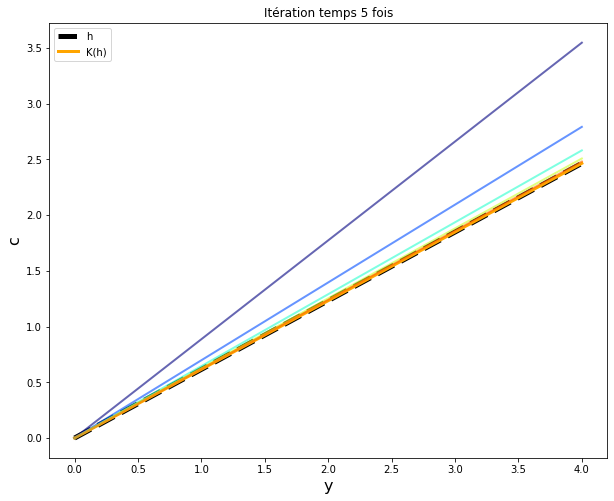

In [10]:
og = QE_OptimalGrowth(alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 4,
                grid_size = 200,
                shock_size = 250)

fig, ax = plt.subplots(figsize=(10,8))
xgrid = og.grid
ax.plot(xgrid, Exact_policy(og, xgrid), 'k--', lw=5, label='h')
ax.plot(xgrid, T_ColemanReffett(og, Exact_policy(og, xgrid)), color='orange', lw=3, label='K(h)')
c_array = 3 * og.grid
num_iter = 5
for i in range(num_iter):
    c_array = T_ColemanReffett(og, c_array)  # Apply the Coleman Reffett operator
    ax.plot(xgrid, c_array, color=plt.cm.jet(i / num_iter), lw=2, alpha=0.6)
ax.set_title('Itération temps %s fois' %num_iter) 
ax.set_xlabel('y', fontsize=16)
ax.set_ylabel('c', fontsize=16)
ax.legend(loc='upper left')
save_results_to = '/Users/guillaumesublet/Dropbox/Economics/Teaching/Montreal/ECN_7055/I_Marches_complets/Cours2_Methodes_Numeriques/'
plt.savefig(save_results_to + 'ECN7055_ColemanReffett.pdf', dpi = 300)
plt.show()